# Leverage
by Maxwell Margenot and Delaney Granizo-Mackenzie

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---

## What is leverage?

Leverage is borrowing money, then investing that money into some trading strategy so as to effectively multiply your initial capital base by some amount.

### More Specifically

Leverage is reinvesting debt to gain a greater return on an investment. We include debt in our asset portfolio as a financial instrument that pays one large cash flow upfront (the loan) and gradually pays negative cash flows out over time. The size of these negative cash flows is determined by the interest rate on our debt. The large upfront cashflow allows us to supplement our capital base. In this way we use our capital and our leverage together to purchase the assets necessary to execute our trading strategy.

### Why would you do this?

If you are confident in a strategy and believe it to be low risk, you can put more money than you currently have into that strategy in an effort to multiply your returns. You of course have to have confidence that the returns on your strategy will exceed the interest rate on your debt.

#### Risk Adjusted Returns

We'll talk about this more later, but risk adjusted return is expressed in the Sharpe Ratio (excess returns/risk). A strategy with a high Sharpe Ratio may not have good absolute returns, say $2\%$ annually, but if the Sharpe Ratio is high the risk will also be correspondingly low. Multiplying the capital base multiplies both the risk and returns of the strategy, keeping the Sharpe Ratio the same. See lower in the notebook for more.

## How do I use leverage?

In the context of algorithmic trading we are specifically interested in margin and trading on margin. Trading on margin is a type of leverage as it involves taking out a loan from your broker and adding it to your capital base in order to increase the returns of your trading strategy. Since you are borrowing money to invest, you ideally only trade on margin when the returns of your strategy are greater than the interest that you pay on that debt. At many points in the execution of a trading strategy, you may attempt to make trades that would exceed your current capital. At this point, the broker checks if you are authorized to trade on margin (borrow money) and, if so, lends you the money necessary to execute the trade. Each person’s margin account will have different terms depending on their broker, size of account, risk of strategies, and other factors. 

If you have a profitable strategy, using leverage can prop up the amount of money that you make overall by padding the money that you are working with. The involvement of the broker is an important factor to consider when constructing algorithmic trading strategies because your trading strategy will borrow automatically as needed when you need more money to cover a position. You may want to limit how much leverage your strategy can take on so that you are not borrowing more than you are comfortable with.

We measure the current leverage of a portfolio by examining the leverage ratio. The leverage ratio of an algorithm is calculated as the sum of your debt and your capital base divided by your capital base. We limit the amount of leverage that our strategy uses by limiting the leverage ratio.

$$ \text{Leverage Ratio} = \frac{\text{Debt} + \text{Capital Base}}{\text{Capital Base}}$$

Let's look at a very simple example of how introducing leverage can affect a portfolio. Consider a single period model, consisting of today and tomorrow, in which we receive our returns tomorrow.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from __future__ import division

In [2]:
capital_base = 100000
r_p = 0.05 # Aggregate performance of assets in the portfolio
r_no_lvg = capital_base * r_p
print 'Portfolio returns without leverage: {0}'.format(r_no_lvg)

Portfolio returns without leverage: 5000.0


This is what portfolio returns look like without leverage. Let's add some debt, leveraging the portfolio, and see how the returns change.

In [3]:
debt = 100000

r_lvg = (capital_base + debt) * r_p
r_lvg_pct = r_lvg / capital_base
# Returns are calculated over the initial capital base
# Think of the debt as an asset purchased and added to the portfolio
lvg_ratio = (debt + capital_base) / capital_base
print 'Portfolio returns with leverage: {0}'.format(r_lvg)
print 'Percentage returns with {1}x leverage: {0}'.format(r_lvg_pct, lvg_ratio)

Portfolio returns with leverage: 10000.0
Percentage returns with 2.0x leverage: 0.1


This is the ideal situation, that someone would lend you money without asking for anything in return. It results in double the effective additive returns of an unlevered strategy, which is just delightful. However, we know that in the real world there is no way that this would actually happen. Let's consider what happens when we add in the effects of an interest payment in our one-period model.

In [4]:
capital_base = 100000
debt = 50000
i = 0.02
r_p = 0.05

int_pmt = i * debt
r_lvg = (capital_base + debt) * r_p
r_total = r_lvg - int_pmt
r_pct_lvg = r_total / capital_base
lvg_ratio = (capital_base + debt) / capital_base
print 'Portfolio returns with leverage and interest: {0}'.format(r_total)
print 'Percentage returns with {1}x leverage and {2}% interest: {0}'.format(r_pct_lvg, lvg_ratio, i * 100)

Portfolio returns with leverage and interest: 6500.0
Percentage returns with 1.5x leverage and 2.0% interest: 0.065


That makes a lot more sense. It would be unreasonable for us to assume that we can add someone else's money to our portfolio without some sort of repayment schedule. Our returns are not as high as they were in the levered portfolio with no interest, but we are still gaining a greater amount of wealth by using leverage, despite the interest rates. As long as we have a reliable strategy that can make sufficient returns to offset the cost of debt we will be able to benefit from levering a portfolio.

Our additive returns have increased over our unlevered strategy, but overall we are gaining a lower percentage return. This is not entirely a bad thing, as with a larger amount of money to trade on we are able to add more overall value to our portfolio. However, if we are not careful with how we manage leverage, we could potentially end up spending all of our profits trying to pay off the interest that we accrued to make them in the first place.

This single-period model is only a small piece of the story. Loans are rarely, if ever, paid off in one period. Payments are spread out over the life of a loan, ensuring that you do not simply get the money for free. In this context, to properly earn a profit using the leverage, we obviously have to be making more money than we are paying out.

## How do I get leverage?

Naturally, borrowing money to do anything will incur interest payments and additional fees. When trading with leverage, or on margin, these loans will come from your broker. Many brokers are loathe to part with their cash without a good reason. Using leverage with high volatility strategies can be dangerous unless you have a high tolerance for risk. Even if you lose money, you still have to pay the broker!

## Leverage in an algorithm

Handling leverage gets significantly more complicated when we are dealing with an algorithm. Every time an algorithm rebalances its portfolio or makes a trade, there is a possibility of affecting the leverage ratio. If there isn't enough cash on hand to cover its positions it will need to borrow more. In the same vein, it may be utilizing overall less cash for the next set of trades, decreasing the leverage ratio.

This is a backtest from our template long-short algorithm attached to our [long-short equity lecture](https://www.quantopian.com/lectures/long-short-equity) over the year 2015 (Note that an upgrade to this template algorithm is coming soon).

In [5]:
bt = get_backtest('57e297562a42c9103c11a920')

100% Time: 0:00:03|###########################################################|


In [6]:
recorded_vars = bt.recorded_vars
leverage = recorded_vars['leverage']
daily_performance = bt.daily_performance
daily_returns = daily_performance['returns']

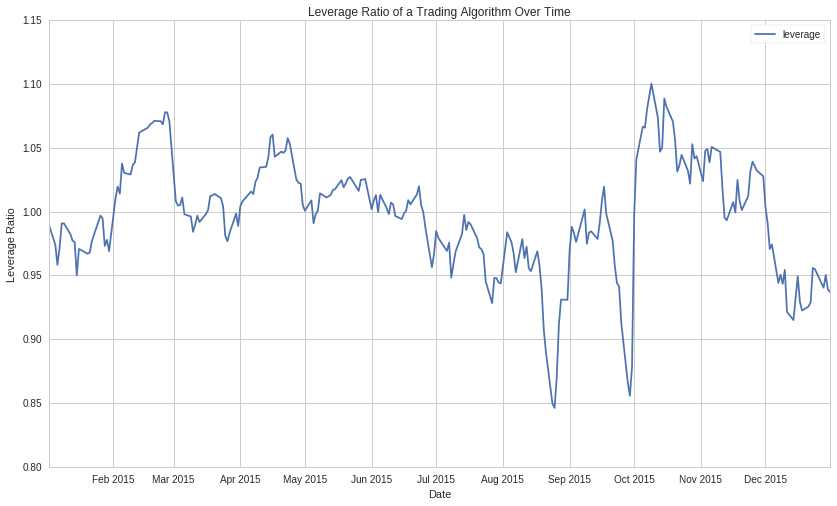

In [7]:
plt.plot(leverage);
plt.title("Leverage Ratio of a Trading Algorithm Over Time")
plt.xlabel('Date');
plt.ylabel('Leverage Ratio');
plt.legend();

Here is the leverage ratio of this algorithm plotted over time. Notice how it jumps around quite frequently. The ratio is below $1$ when it is not using all of its base capital and it spikes above $1$ whenever it makes a trade on margin. The algorithm associated with this leverage ratio is a long-short equity algorithm based on a combination of fundamental factors. For an overview of how a long-short equity strategy works, please see the [lectures](https://www.quantopian.com/lectures/long-short-equity) page.

A key feature of this sort of strategy is that it can trade hundreds, sometimes even thousands of equities at once. As such, we run the risk of incurring some fairly large rebalancing costs, depending on how frequently we rebalance. This algorithm specifically rebalances on a monthly basis. As we can see on the above graph of the leverage ratio, a lot of the largest changes occur aroud the start of each month.

To see how the rebalancing structure and maximum leverage can affect the leverage ratio of the algorithm when it is executed, go into the the template and modify these parameters. Changing the type of algorithm will also drastically affect how it uses leverage. Feel free to experiment.

Things to try:
1. Change the timing of the rebalancing between daily, monthly, and weekly.
2. Modify the amount of leverage that the portfolio is allowed to take on
3. Restrict the universe that the algorithm trades within by applying more filters to your trading universe.
4. Instead of making all portfolio weights equally-weighted, use a portfolio optimization scheme like [Markowitz or Mean Absolute Deviation](https://www.quantopian.com/posts/mad-portfolio-an-alternative-to-markowitz) portfolio optimization.


Here are the associated returns of this algorithm. The volatility of these returns is important to take into account when examining the leverage of a strategy.

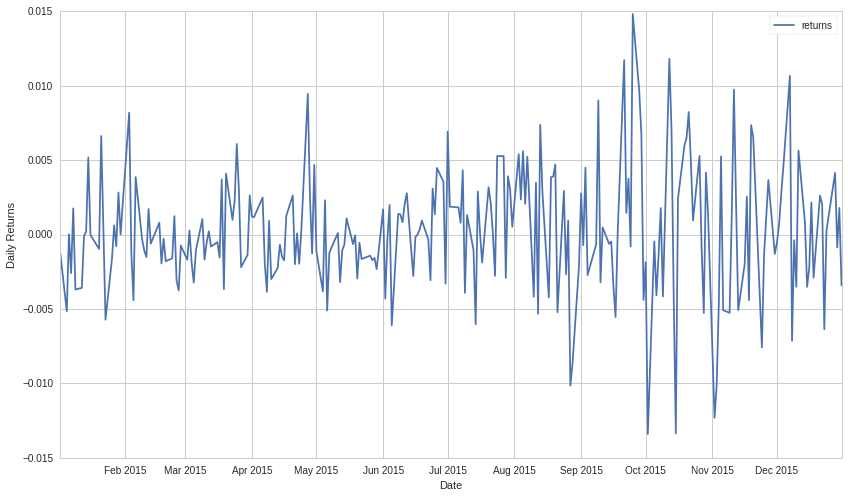

In [8]:
plt.plot(daily_returns);
plt.xlabel('Date');
plt.ylabel('Daily Returns');
plt.legend();

In [9]:
print "Mean return: ", daily_returns.mean()
print "Volatility: ", daily_returns.std()

Mean return:  0.000205560596422
Volatility:  0.00413576215927


Using leverage can be dangerous when you are dealing with a more volatile strategy. Because you are trading with borrowed money, we are on the hook to return it. We have to make sure that the broker gets his money back before we get our profit. If we end up in a position where we get a margin call, we have to pony up more funds if we want to hold our positions. Monitoring your strategy's volatility and ensuring you are only taking on palatable amounts of debt are key aspects of determining the quality of your trading strategy.

## Risk-Adjusted Returns

Comparing returns of different investment opportunities without taking risk into account is meaningless. Some return streams may be higher than others, but this may be due to the risks taken on rather than any merit in the strategy itself. Taking on higher risk should in theory lead to higher returns, but then how do we judge the quality of these returns for the amount of risk we have to handle? This is where risk-adjusted returns and methods of risk-adjustment come into play. If we adjust several return streams for risk then we can consider them on equal footing, independent of the risk. This allows us to effectively compare and determine which return streams are the best for a given desired risk profile.`

One of the most prominent risk-adjusted measures is the Sharpe Ratio, defined as follows.

$$ \text{Sharpe Ratio} = \frac{r_p - r_f}{\sigma_p} $$

The Sharpe Ratio essentially normalizes the returns of a portfolio, giving us a metric that we can use as a measure of quality relative to other revenue streams. A higher Sharpe Ratio indicates that you are getting more return relative to the risk that your strategy is taking on.

#### Compare Strategies by Sharpe Ratio and then Lever as Needed

In general you want to compare the Sharpe Ratio of two strategies you may be interested in. Pick the strategy with the better Sharpe Ratio and then use leverage to multiply the returns up to where you want them. Assuming constraints like capital capacity don't kick in, you can add more money through leverage and bring a $2\%$ per year strategy up to a $10\%$ per year strategy while maintaining the same Sharpe, or invest a fraction of your available capital to bring a $20\%$ per year strategy's risk down to acceptable levels.

#### Example

We'll show a simple example using real numbers.

In [10]:
# Note these are all expected returns. You need to validate that
# your strategy will continue to produce these returns and volatility using other methods.
# Just measuring historically is a very poor predictor of future performance.
# We'll for now assume you've already validated that you can expect to keep seeing numbers similar to these.

strat_A_ann_return = 0.22
strat_A_ann_vol = 0.15

strat_B_ann_return = 0.05
strat_B_ann_vol = 0.02

# We'll assume a risk free rate of 0.02
risk_free_rate = 0.02

print 'Strategy A Sharpe: %s' % ((strat_A_ann_return - risk_free_rate) / strat_A_ann_vol)
print 'Strategy B Sharpe: %s' % ((strat_B_ann_return - risk_free_rate) / strat_B_ann_vol)

# Add in leverage to B

leverage = 3
# Expressed in returns

print 'Strategy B Sharpe: %s' % (
    (strat_B_ann_return * leverage - risk_free_rate * leverage) / (strat_B_ann_vol * leverage)
)
print 'Strategy B Levered Annual Returns: %s' % (
    (strat_B_ann_return * leverage - risk_free_rate * leverage)
)

Strategy A Sharpe: 1.33333333333
Strategy B Sharpe: 1.5
Strategy B Sharpe: 1.5
Strategy B Levered Annual Returns: 0.09


### Portfolio Re-Weighting

Portfolio weighting can be considered an example of applying leverage to a strategy. If you assign more of your portfolio weight to a strategy, you have upped the capital amount and multiplied both the returns and volatility. Likewise, if you have a strategy that has high returns but high volatility, you can provide it less weight so that you divide the volatility.

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*